# Deep Q Network로의 여행 연습
# Part IV. +CNN

![좋은 그림](https://d3i71xaburhd42.cloudfront.net/e6a1640c03c50a55ef3e00a0592dbb0851fe33bb/3-Figure1-1.png)

[읽어보면 좋은 것 0](https://www.katnoria.com/static/e59c56013a5d82a0ae94d9413076dfc0/1e043/dqn_algo.png)<br>
[읽어보면 좋은 것 1](https://arxiv.org/pdf/1312.5602.pdf)<br>
[읽어보면 좋은 것 2](https://web.stanford.edu/class/psych209/Readings/MnihEtAlHassibis15NatureControlDeepRL.pdf)



# 라이브러리 설치 / 불러오기

In [1]:
%%time
## 약 25초 ~30초 소요
!pip install pyvirtualdisplay 
!apt-get install -y xvfb python-opengl ffmpeg
!pip install gym
!pip install box2d-py
#!pip install pyglet==1.3.2
!pip install pyglet

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
Suggested packages:
  libgle3
The following NEW packages will be installed:
  python-opengl xvfb
0 upgraded, 2 newly installed, 0 to remove and 10 not upgraded.
Need to get 1,280 kB of archives.
After this operation, 7,686 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-opengl all 3.1.0+dfsg-1 [496 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.8 [784 kB]
Fetched 1,280 kB in 1s (1,552 kB/s)
Selecting previously unselected package python-opengl.
(Reading database ... 146442 files and directories currently installed.)
Preparing to unpack .../python-opengl_3.1.0+dfsg-1_all.deb ...
Unpacking python-opengl (3.1.0+dfsg-1) ...
Selecting previously unselected package xvfb.
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.8_amd

In [2]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

In [3]:
display = Display(visible=0, size=(1400, 900))
display.start()

비디오 녹화용 함수

In [4]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[-1]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

#  Assault-v0

[Assault-v0 링크](https://gym.openai.com/envs/Assault-v0/)
<br>
<img src='https://miro.medium.com/max/740/1*RFR3VaN9_xUxHIELCrOYHw.gif'>

observation space: Box(0, 255, (250, 160, 3), uint8)
action space: Discrete(7)
steps:  904


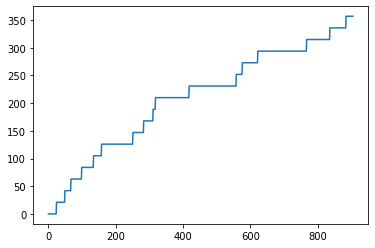

In [5]:
env = wrap_env(gym.make("Assault-v0"))
print('observation space:', env.observation_space)
print('action space:', env.action_space)

rewards_cums = []
rewards_cum = 0
state = env.reset()
for t in range(1000):
    action = env.action_space.sample() # your agent here (this takes random actions)
    env.render()
    observation, reward, done, info = env.step(action)
    rewards_cum = rewards_cum + reward
    rewards_cums.append(rewards_cum)
    if done: 
      break;
            
print('steps: ', t)
env.close()
show_video()
plt.plot(rewards_cums)
plt.show()

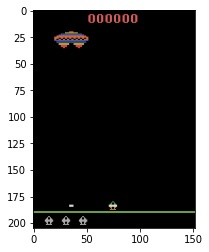

In [6]:
plt.imshow(env.reset()[35:-10,4:-4,:])

# 전처리가 필요하다!

1. 컬러 --> 그레이스케일(흑백) : 조금이라도 덜 복잡하도록.
2. 필요 없는 하단(에이전트 아래)을 제거
3. 픽셀 값 min-max scaling
4. [110,84] 사이즈로 resize : 조금이라도 사이즈가 작도록.

In [7]:
from skimage import transform
from skimage.color import rgb2gray

In [8]:
def preprocess_frame(frame):
    gray = rgb2gray(frame)
    cropped_frame = gray[35:-10,4:-4]
    scaled_frame = cropped_frame/255
    resized_frame = transform.resize(scaled_frame, [110, 84])

    return resized_frame

# Stack Frame

1. 연속된 4개의 이미지를 묶는다. '모션'을 인식시킬 수 있지 않을까?

In [9]:
from collections import deque

In [10]:
stack_size = 4

stacked_frames  =  deque([np.zeros((110,84), dtype=np.int) for i in range(stack_size)], maxlen=4)

def stack_frames(stacked_frames, state, is_new_episode):
    # Preprocess frame
    frame = preprocess_frame(state)
    
    if is_new_episode:
        # 새로 시작하는 상황이라면, stacked_frames를 비우고 새로 만든다.
        stacked_frames = deque([np.zeros((110,84), dtype=np.int) for i in range(stack_size)], maxlen=4)
        
        # 그리고 똑같은 시작 state(frame)을 4개 스택!
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        stacked_frames.append(frame)            
        stacked_state = np.stack(stacked_frames, axis=2).reshape([-1,110,84,4])
        
    else:
        # 자동으로 오래된 프레임은 날린다.
        stacked_frames.append(frame)
        stacked_state = np.stack(stacked_frames, axis=2).reshape([-1,110,84,4])
    
    return stacked_state, stacked_frames

# Convolutional Neural Network for Q-function

**Q-function기능을 할 뉴럴넷을 구성할 것이다.**
1. input은 state다. (노드 수는?)
2. output은 그 state에서 취할 수 있는 action에 대한 Q값이다. (노드 수는?)

[좋은그림](https://img1.daumcdn.net/thumb/R800x0/?scode=mtistory2&fname=https%3A%2F%2Ft1.daumcdn.net%2Fcfile%2Ftistory%2F9911AF455B9A0A9706)<br>
[좋은그림1](https://theaisummer.com/assets/img/posts/Taking_Deep_Q_Networks_a_step_further/DDQN.jpg)

![좋은그림1](https://i.ytimg.com/vi/2-zGCx4iv_k/hqdefault.jpg)


In [11]:
print("state 수는? : ", env.observation_space.shape)
print("action 수는? : ", env.action_space.n)

state 수는? :  (250, 160, 3)
action 수는? :  7


In [12]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Input, Dense, Add, Conv2D, Flatten, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import plot_model

In [13]:
### 이것은 일단 그냥 사용해보자!
### huber 로스!
from tensorflow.keras.losses import Huber
def mean_huber_loss(y_true, y_pred, clip_delta=1.0):
    return tf.keras.backend.mean(Huber(clip_delta)(y_true, y_pred))

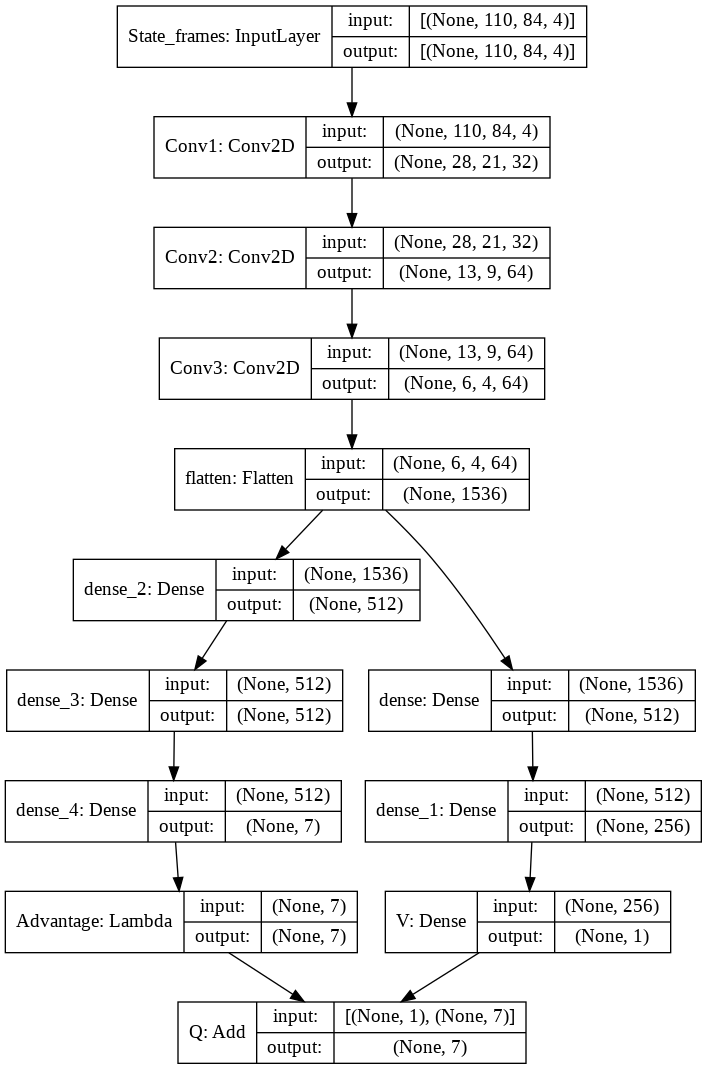

In [14]:
keras.backend.clear_session()
######################
### Your Code Here ###
######################

state_layer = Input(shape=(110,84,4), name='State_frames')
hc = Conv2D(32, kernel_size=(8,8), strides=(4,4),
            padding='same', activation='elu', name='Conv1')(state_layer)
hc = Conv2D(64, kernel_size=(4,4), strides=(2,2),
            padding='valid', activation='elu', name='Conv2')(hc)
hc = Conv2D(64, kernel_size=(3,3), strides=(2,2),
            padding='valid', activation='elu', name='Conv3')(hc)
hidden = Flatten()(hc)

hv = Dense(512, activation='relu')(hidden)
hv = Dense(256, activation='relu')(hv)
v_layer = Dense(1, name='V')(hv)

ha = Dense(512, activation='relu')(hidden)
ha = Dense(512, activation='relu')(ha)
a_layer = Dense(env.action_space.n)(ha)
a_layer = Lambda(lambda a: a[:, :] - tf.keras.backend.mean(a[:,:],axis=1, keepdims=True ),name='Advantage')(a_layer)

q_layer = Add(name="Q")([v_layer, a_layer]) #Broadcast 해준다

Q_network = Model(state_layer, q_layer)

Q_network.compile(loss = mean_huber_loss,
              optimizer = Adam())

# Q_network.summary()

plot_model(Q_network, show_shapes=True)

### 위 코드를 보고 target_Q_network를 구성하시오.

* 똑같으면 된다.
* 단, 모델 이름은 target_Q_network

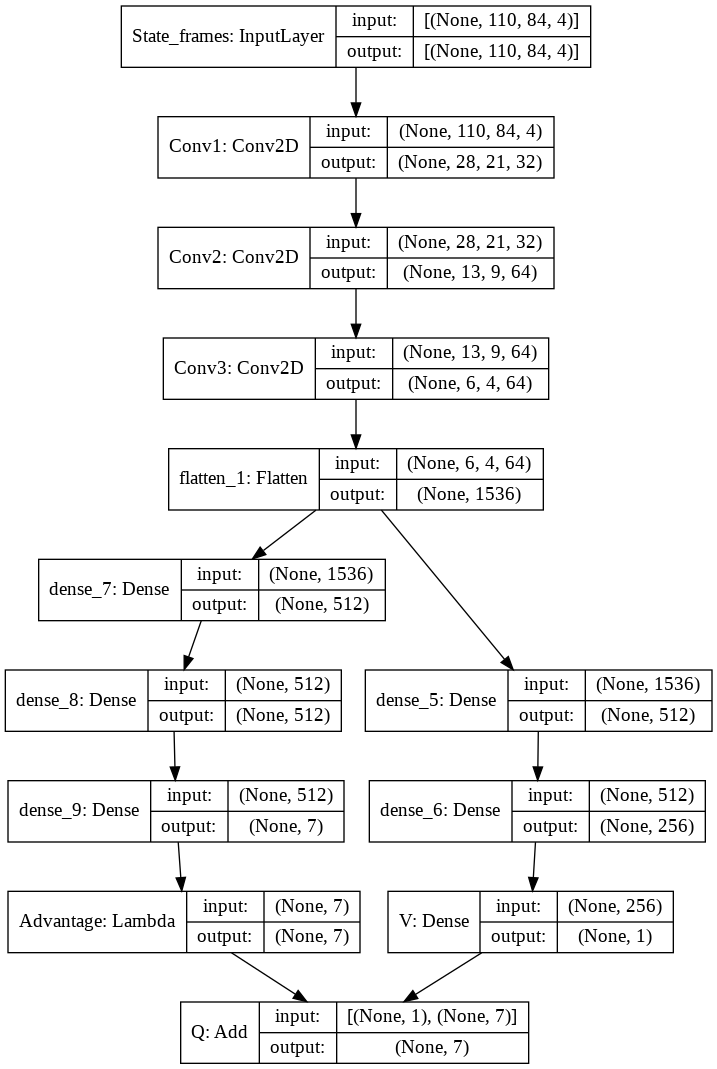

In [15]:
# keras.backend.clear_session()
######################
### Your Code Here ###
######################

state_layer = Input(shape=(110,84,4), name='State_frames')
hc = Conv2D(32, kernel_size=(8,8), strides=(4,4),
            padding='same', activation='elu', name='Conv1')(state_layer)
hc = Conv2D(64, kernel_size=(4,4), strides=(2,2),
            padding='valid', activation='elu', name='Conv2')(hc)
hc = Conv2D(64, kernel_size=(3,3), strides=(2,2),
            padding='valid', activation='elu', name='Conv3')(hc)
hidden = Flatten()(hc)

hv = Dense(512, activation='relu')(hidden)
hv = Dense(256, activation='relu')(hv)
v_layer = Dense(1, name='V')(hv)

ha = Dense(512, activation='relu')(hidden)
ha = Dense(512, activation='relu')(ha)
a_layer = Dense(env.action_space.n)(ha)
a_layer = Lambda(lambda a: a[:, :] - tf.keras.backend.mean(a[:,:],axis=1, keepdims=True ),name='Advantage')(a_layer)

q_layer = Add(name="Q")([v_layer, a_layer]) #Broadcast 해준다

target_Q_network = Model(state_layer, q_layer)

target_Q_network.compile(loss = mean_huber_loss,
              optimizer = Adam())

# Q_network.summary()

plot_model(target_Q_network, show_shapes=True)

In [16]:
## Target Q 네트워크의 가중치는 같아야 한다.
target_Q_network.set_weights(Q_network.get_weights())

# Memory 구현 & Memory에 어느정도 Experience를 담아두기!

1. (s0, a0, r1, s1, done)을 담아두면 된다. 튜플!
2. deque를 이용하여 최근 n개의 Experience만 담아둘수 있도록 한다.
3. Experience 를 replay하며 배울 때는..
    * sample_size = bach_size = 128 개씩 경험을 랜덤추출하여 .fit()할 것이다!
    * 따라서 experience(s0, a0, r1, s1, done)은 충분히 미리 담아두자.
    * 랜덤액션으로 담아두어도 좋다.

In [17]:
from collections import deque
memory = deque(maxlen = 20000)  # 리스트 처럼 사용이 가능하다.

In [18]:
alpha = 0.1
gamma = 0.95
n_episod = 100
epsilon = 0.1
pre_play = 10 # 실제 담기는건 10개가 아님.

for i in range(pre_play) :
    print(i, " 번째 에피소드,")
    s0 = env.reset()
    s0, stacked_frames = stack_frames(stacked_frames, s0, True)
    done = False

    while True :

        a0 = env.action_space.sample() # 랜덤 액션!
        # 환경과 상호작용!
        s1, r1, done, _ = env.step(a0)
        s1, stacked_frames = stack_frames(stacked_frames, s1, False)

        if done == False :
            memory.append( (s0, a0, r1, s1, done) )
            s0 = s1
        else :
            s1 = np.zeros(s0.shape)  # 끝나면 s1가 0이 됨!
            memory.append( (s0, a0, r1, s1, done) )
            env.close()
            break
    print("저장된 experience : {}".format(len(memory)))

0  번째 에피소드,
저장된 experience : 389
1  번째 에피소드,
저장된 experience : 909
2  번째 에피소드,
저장된 experience : 1672
3  번째 에피소드,
저장된 experience : 2399
4  번째 에피소드,
저장된 experience : 3327
5  번째 에피소드,
저장된 experience : 3968
6  번째 에피소드,
저장된 experience : 4807
7  번째 에피소드,
저장된 experience : 5494
8  번째 에피소드,
저장된 experience : 6288
9  번째 에피소드,
저장된 experience : 6860


In [19]:
print(f'리스트 메모리 길이 : {len(memory)}')
print(f'* 메모리 내용 1개 보기')
print(f'  - 메모리 첫번째(리스크 첫번째) : s0(1,110,84,4), a0(0~6중 max), r1(int), s1(1,110,84,4), done(boolean) 구성')
print(f'  - s0 : {memory[0][0].shape}')
print(f'  - a0 : {memory[0][1]}')
print(f'  - r1 : {memory[0][2]}')
print(f'  - s1 : {memory[0][3].shape}')
print(f'  - done : {memory[0][4]}')

리스트 메모리 길이 : 6860
* 메모리 내용 1개 보기
  - 메모리 첫번째(리스크 첫번째) : s0(1,110,84,4), a0(0~6중 max), r1(int), s1(1,110,84,4), done(boolean) 구성
  - s0 : (1, 110, 84, 4)
  - a0 : 1
  - r1 : 0.0
  - s1 : (1, 110, 84, 4)
  - done : False


# Memory로 부터 배치 사이즈 만큼 데이터를 떼어 오는 함수 제작

* .fit(s0, target_Q) 임을 고려하자
* 심지어 이제 진짜 target_Q_network 를 이용하여 만들어야 하는것이 맞다.


In [20]:
import random
def create_batch(target_model, memory, gamma, batch_size = 128):
    sample = np.array(random.sample(memory, batch_size))

    s0 = sample[:, 0]
    a0 = sample[:, 1].astype(np.int8)
    r1 = sample[:, 2]
    s1 = sample[:, 3]
    d = sample[:, 4]

    s0_batch = np.vstack(s0)
    s1_batch = np.vstack(s1)

    target_Q_batch = target_model.predict(s0_batch)
    Q_s1 = target_model.predict(s1_batch)
    #### Target_Q update
    target_Q_batch[np.arange(batch_size),a0] = r1 + gamma*np.max(Q_s1, axis=1)*(1-d)

    return s0_batch, target_Q_batch

# Memory로 부터 학습 하는 Q-Network!

In [21]:
s0.shape, s1.shape

((1, 110, 84, 4), (1, 110, 84, 4))

episode 1 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 2 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


===========  에피소드 : 2  ============
최종누적보상 : 336.0
0 [[ 3.3554682e-04  4.5019231e-05  1.0454973e-04  2.8145325e-05
   1.2751232e-04  3.0579482e-05 -1.4856688e-04]]


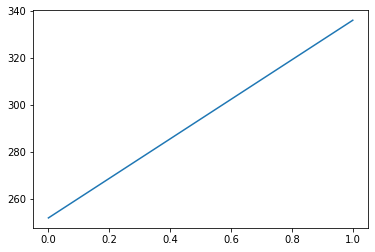

episode 3 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


episode 4 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


===========  에피소드 : 4  ============
최종누적보상 : 126.0
0 [[ 9.9844867e-05 -9.0530521e-05 -4.2082745e-05  1.7640559e-06
  -1.1214289e-04 -2.4018761e-04 -2.2187486e-04]]


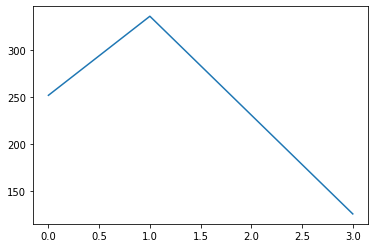

episode 5 --진행 중


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


KeyboardInterrupt: ignored

In [22]:
env.close()
alpha = 0.1
gamma = 0.9
n_episod = 1000

epsilon = 1

sample_size = batch_size = 64
cum_rewards = []
tq_update = 10 ## target_Q는 언제 업데이트 할래?

for i in range(n_episod) :
    print("episode {} --진행 중".format(i+1))
    env = wrap_env(gym.make("Assault-v0"))
    s0 = env.reset()
    s0, stacked_frames = stack_frames(stacked_frames, s0, True)
    done = False

    cum_r = 0
    time_step = 0
    while True :
        Q_s0 = Q_network.predict(s0)  #s0에서의 action들의 Q_value
        epsilon = max(0.1, epsilon*0.9995)
        # 행동 선택하기 e-greedy 방법
        if np.random.uniform() < epsilon :
            a0 = env.action_space.sample()
        else : 
            a0 = np.argmax(Q_s0)

        # a0 이용하여 환경과 상호작용!
        s1, r1, done, _ = env.step(a0)
        s1, stacked_frames = stack_frames(stacked_frames, s1, False)

        # 메모리에 저장!
        memory.append((s0, a0, r1, s1, done))
        # 학습을 위해 Experience Replay!
        # create_batch 조심.
        s0_batch, target_Q_batch = create_batch(target_Q_network, memory, gamma, batch_size=batch_size) 
        # 학습
        Q_network.fit(s0_batch, target_Q_batch, epochs=0, verbose=1, batch_size=batch_size)

        cum_r = cum_r + r1

        time_step = time_step + 1
        if time_step % tq_update == 0 :
            ## Target Q 네트워크의 가중치 업데이트
            target_Q_network.set_weights(Q_network.get_weights())

        if done == True : # 종료 되었다면
            cum_rewards.append(cum_r)
            env.close() # 환경닫고
            ## Target Q 네트워크의 가중치 업데이트
            target_Q_network.set_weights(Q_network.get_weights())
            break # 멈추자.

        s0 = s1 # 다음 루프에선 이것이 직전 state

    if (i+1) % 2 == 0 :
        print('===========  에피소드 : {}  ============'.format(i+1))
        print('최종누적보상 :',cum_r)
        print(a0, Q_s0)
        plt.plot(cum_rewards)
        plt.show()
        show_video()